In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#  读取数据

In [40]:
print(os.listdir())

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('数据已经读取完成')


['.idea', '.ipynb_checkpoints', 'best_submission.csv', 'data_description.txt', 'HP.py', 'H_P.ipynb', 'sample_submission.csv', 'Sub.csv', 'Submission.csv', 'Submission1.csv', 'test.csv', 'title.csv', 'train.csv', 'xgb.csv']
数据已经读取完成


In [41]:
quantitative = [i for i in train.columns if train.dtypes[i]!='object'] # 取定量指标 （其中包含ID[无用]，SalePrice[需要预测，为y]）
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitive = [i for i in train.columns if train.dtypes[i] =='object'] #取定性指标

# 观察缺失值

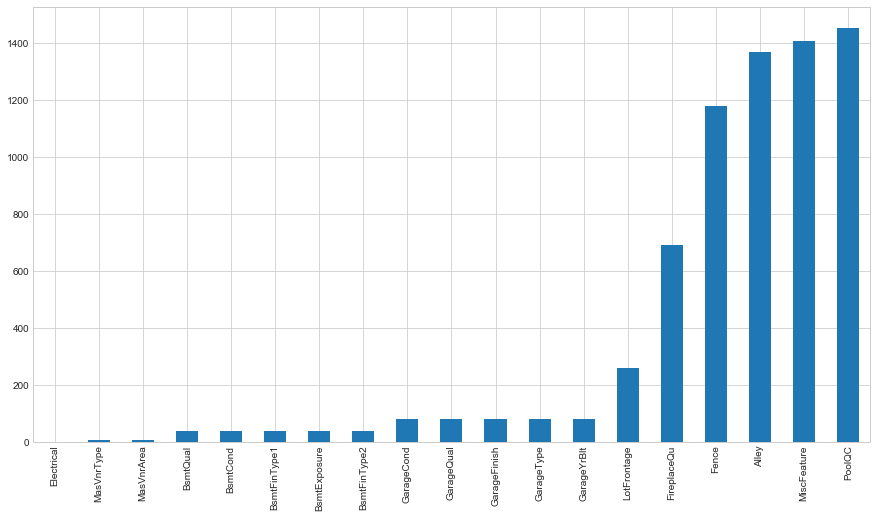

In [42]:
plt.figure(figsize=(15, 8))
sns.set_style('whitegrid')
missing = train.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()
plt.show()

# 对y进行观察

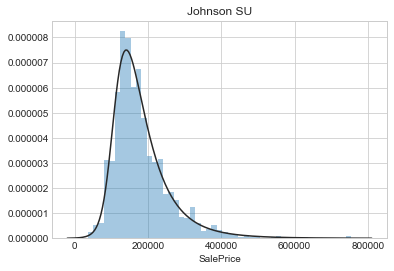

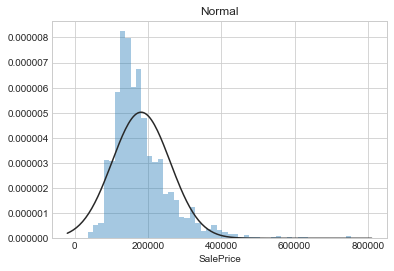

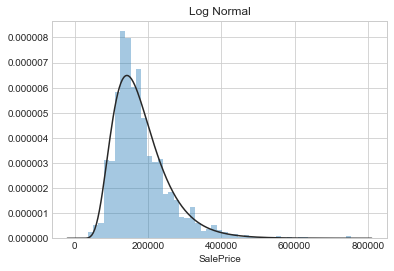

In [43]:
y = train['SalePrice']
plt.figure(1)
plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2)
plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3)
plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)
plt.show()

# 证明定量指标不满足正态

In [44]:
test_normality = lambda x: stats.shapiro(x.fillna(int(x.median())))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality) 
print(not normal.any())  # 证明跟正态分布关系不大

False


In [45]:
stats.shapiro(train[quantitative[0:5]].fillna(0))[1]

0.0

In [46]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature,'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()# 每个特征所对应的房价的均值 由高到低 标注为1、2、3 生成特征1：1，特征2：2的字典
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [47]:
# qual_encoded = []
# for q in qualitive:  
#     encode(train, q)
#     qual_encoded.append(q+'_E')
# print(qual_encoded)

In [48]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
# features = quantitative + qual_encoded
features = quantitative + qualitive

In [80]:
qual_encoded

['MSZoning_E',
 'Street_E',
 'Alley_E',
 'LotShape_E',
 'LandContour_E',
 'Utilities_E',
 'LotConfig_E',
 'LandSlope_E',
 'Neighborhood_E',
 'Condition1_E',
 'Condition2_E',
 'BldgType_E',
 'HouseStyle_E',
 'RoofStyle_E',
 'RoofMatl_E',
 'Exterior1st_E',
 'Exterior2nd_E',
 'MasVnrType_E',
 'ExterQual_E',
 'ExterCond_E',
 'Foundation_E',
 'BsmtQual_E',
 'BsmtCond_E',
 'BsmtExposure_E',
 'BsmtFinType1_E',
 'BsmtFinType2_E',
 'Heating_E',
 'HeatingQC_E',
 'CentralAir_E',
 'Electrical_E',
 'KitchenQual_E',
 'Functional_E',
 'FireplaceQu_E',
 'GarageType_E',
 'GarageFinish_E',
 'GarageQual_E',
 'GarageCond_E',
 'PavedDrive_E',
 'PoolQC_E',
 'Fence_E',
 'MiscFeature_E',
 'SaleType_E',
 'SaleCondition_E']

# 数据处理

In [49]:
from sklearn.manifold import TSNE # 降维
from sklearn.preprocessing import StandardScaler # 标准化
model = TSNE(perplexity=50)
from sklearn.cluster import KMeans

In [50]:
# from sklearn.decomposition import PCA
# X = train[features].fillna(0).values
# tsne = model.fit_transform(X)

# std = StandardScaler()
# st = std.fit_transform(X)
# PCA = PCA(n_components=30)
# pca = PCA.fit_transform(st)
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(pca)

In [51]:
# fr = pd.DataFrame(
#     {'tsne1':tsne[:,0],
#      'tsne2':tsne[:,1],
#      'cluster':kmeans.labels_ # tesne 降维后，用k近邻标注
#     }
# )
# sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
# plt.show()

In [52]:
train['label_'] =1
train.drop(['Id'],axis=1,inplace=True)
Id = test.Id
test['label_'] = 0
test.drop(['Id'],axis=1,inplace=True)

In [53]:
train = train[train.GrLivArea<4000]
train.reset_index(drop=True, inplace=True)

# 把训练集测试机整合起来 统一处理特征

In [54]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

# 缺失值填充

In [55]:
train.reset_index(drop=True, inplace=True)
y = np.log1p(train['SalePrice']).reset_index(drop=True)# 对y进行标准化
Y = train['SalePrice'].reset_index(drop=True)
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    features[col] = features[col].fillna('None')
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [56]:
object_ = []
numeries = []
for i in features.columns:
    if features[i].dtypes ==object:
        object_.append(i)
    else:
        numeries.append(i)
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
features.update(features[object_].fillna('None'))
features.update(features[numeries].fillna(0))

In [57]:
from scipy.stats import skew
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_feature = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

In [58]:
high_skew = skew_feature[skew_feature>0.5]

In [59]:
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
skew_index = high_skew.index
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i]+1))

In [60]:
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [61]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x>0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [62]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2915, 310)

In [63]:
test_x = final_features[final_features['label_']==0]
train_x = final_features[final_features['label_']==1]
train_x.shape,test_x.shape

((1456, 310), (1459, 310))

In [64]:
test_x.drop(['label_'],axis=1, inplace=True)
train_x.drop(['label_'],axis=1, inplace=True)

In [65]:
final_features.drop(['label_'], axis=1, inplace=True)

In [66]:
X = final_features.iloc[:len(Y),:]
X_sub = final_features.iloc[len(Y):,:]
X.shape,y.shape,X_sub.shape,Y.shape

((1456, 309), (1456,), (1459, 309), (1456,))

# 删除过拟合值（无用值）

In [67]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])
Y = Y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:  
        overfit.append(i) # 删除只有一个值或者一个值占比99.94的特征

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)


In [68]:
test_x = test_x.drop(overfit, axis=1)

In [69]:
X.shape, y.shape, X_sub.shape,test_x.shape,Y.shape

((1451, 304), (1451,), (1459, 304), (1459, 304), (1451,))

In [70]:
Kfold = KFold(n_splits=10, shuffle=True, random_state=42)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, Y, scoring='neg_mean_squared_error', cv=Kfold))
    return rmse

In [71]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [72]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=Kfold))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=Kfold))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=Kfold, l1_ratio=e_l1ratio))
svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)  
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [73]:
# score = cv_rmse(ridge)
# print(f"Ridge: {score.mean()} ({score.std()})\n{datetime.now()}")
# score = cv_rmse(lasso)
# print(f"Lasso: {score.mean()} ({score.std()})\n{datetime.now()}")
# score = cv_rmse(elasticnet)
# print(f"Elasticnet: {score.mean()} ({score.std()})\n{datetime.now()}")
# score = cv_rmse(svr)
# print(f"SVR: {score.mean()} ({score.std()})\n{datetime.now()}")
# score = cv_rmse(lightgbm)
# print(f"Lightbgm: {score.mean()} ({score.std()})\n{datetime.now()}")
# score = cv_rmse(gbr)
# print(f"GBR: {score.mean()} ({score.std()})\n{datetime.now()}")
score = cv_rmse(xgboost)
print(f"XGBoost: {score.mean()} ({score.std()})\n{datetime.now()}")

XGBoost: 23067.793962894095 (3589.371550909829)
2019-06-06 11:52:35.646204


In [74]:
# print("Start fit")
# print('stack_gen')
# stack_gen_model = stack_gen.fit(np.array(X),np.array(Y))
# print('elasticnet')
# elasticnet_model_full_data = elasticnet.fit(X,Y)
# print('Lasso')
# lasso_model_full_data = lasso.fit(X,Y)
# print('Ridge')
# ridge_model_full_data = ridge.fit(X,Y)
# print('SVR')
# svr_model_full_data = svr.fit(X,Y)
# print('GradientBoosting')
# gbr_model_full_data = gbr.fit(X, Y)
print('xgboost')
xgb_model_full_data = xgboost.fit(X, Y)
# print('lightgbm')
# lgb_model_full_data = lightgbm.fit(X, Y)

xgboost


# Blending model

In [75]:
# def blend_models_predict(X):
#     return ((0.1 * elasticnet_model_full_data.predict(X)) + \
#             (0.05 * lasso_model_full_data.predict(X)) + \
#             (0.1 * ridge_model_full_data.predict(X)) + \
#             (0.1 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
#             (0.15 * xgb_model_full_data.predict(X)) + \
#             (0.1 * lgb_model_full_data.predict(X)) + \
#             (0.3 * stack_gen_model.predict(np.array(X))))
# print('RMSLE score on train data:')
# print(rmsle(y, blend_models_predict(X)))

In [77]:
Sale_ = xgb_model_full_data.predict(test_x)
# Sale_ = np.expm1(blend_models_predict(X_sub))
df = pd.DataFrame(
    {'Id':Id,
     'SalePrice':Sale_,
    }
)
# print(df)
df.to_csv('xgb.csv',index=False)


In [ ]:
Sale_

In [ ]:
train['SalePrice']